In [1]:
print('Importing packages...')
import os
import pandas
import numpy as np
import time
#import zipfile
import geopandas
from matplotlib import pyplot as plt
pandas.set_option('display.max_colwidth', -1)
debug = 1

# Directories to look in
thisdir = '/home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act/'
data_dir = '/home/idies/workspace/Temporary/raddick/cra_scratch_final/'
jobs_dir = data_dir + 'lodes_wac/'
census_dir = data_dir + 'acs5/'
#baltimore_dir = thisdir + 'baltimore/'
code_lookup_dir = thisdir + 'code_guide_lookups/'
inflation_dir = '/home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act/datasets/inflation/'
extrasdir = '/home/idies/workspace/Storage/raddick/census/extras/'
census_shapefile_tiger_basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/'
output_data_dir = thisdir + 'final_data/'

#city_data_dir = thisdir + 'city_data/'
city_data_dir = thisdir + 'final_data/'

g = 0  # keep track of grand total of processing time
os.chdir(thisdir)
print('Now in directory: {0:}'.format(os.getcwd()))
print('ok')

Importing packages...
Now in directory: /home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act
ok


In [2]:
city = 'Baltimore'
state_codes_df = pandas.read_csv(extrasdir+'statecodes.csv', encoding='utf-8', index_col='STATE')

if (city == 'Baltimore'):
    thestate = 24
    state_abbrev = 'md'
    thecounties = [3, 5, 13, 25, 27, 35, 510] # https://en.wikipedia.org/wiki/Baltimore_metropolitan_area
    themsa = 12580
    shapefile_dir = '/home/idies/workspace/Storage/raddick/Baltimore/shapefiles/'
    cityname_file = 'baltimore'
#elif (city == 'St. Louis'):
#    thestate = 29   # state_codes_df[state_codes_df['STATE_NAME'] == 'Missouri']
#    state_abbrev = 'mo'
#    thecounty = 510
#    shapefile_dir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/2017/TRACT/'
#    cityname_file = 'st_louis' 
#elif (city == 'Washington DC'):
#    thestate = 11   # state_codes_df[state_codes_df['STATE_NAME'] == 'Missouri']
#    state_abbrev = 'dc'
#    thecounty = 1
#    shapefile_dir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/2017/TRACT/'
#    cityname_file = 'dc' 
#elif (city == 'Richmond'):
#    thestate = 51   # state_codes_df[state_codes_df['STATE_NAME'] == 'Missouri']
#    state_abbrev = 'va'
#    thecounty = 760
#    shapefile_dir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/2017/TRACT/'
#    cityname_file = 'richmond'  
#elif (city == 'San Francisco'):
#    thestate = 6   # state_codes_df[state_codes_df['STATE_NAME'] == 'California']
#    state_abbrev = 'ca'
#    thecounty = 75
#    shapefile_dir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/2017/TRACT/'
#    cityname_file = 'san_francisco'    
#elif (city == 'Philadelphia'):
#    thestate = 42
#    state_abbrev = 'pa'
#    thecounty = 101
#    shapefile_dir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/2017/TRACT/'
#    cityname_file = 'philadelphia'
else:
    print('ERROR: Select city from list!')
#state_codes_df

print('Selected {0:}!'.format(city))

Selected Baltimore!


# Get tract information

In [3]:
#metro_tracts_years_df.index.values.tolist()
geo_gdf = geopandas.GeoDataFrame()
for thisyear in range(2017, 2010, -1):
    geo_i_gdf = geopandas.read_file(census_shapefile_tiger_basedir+'{0:.0f}/TRACT/tl_{0:.0f}_{1:}_tract.shp'.format(thisyear, thestate))
    geo_i_gdf = geo_i_gdf.assign(year = thisyear)
    geo_gdf = pandas.concat((geo_gdf, geo_i_gdf), axis=0)

geo_gdf = geo_gdf.assign(county = pandas.to_numeric(geo_gdf['COUNTYFP'], errors='coerce'))
geo_gdf = geo_gdf.assign(census_tract = pandas.to_numeric(geo_gdf['TRACTCE'].apply(lambda x: str(x)[0:4] + '.' + str(x)[4:6]), errors='coerce'))

metro_geo_gdf = geo_gdf[geo_gdf['county'].isin(thecounties)]

# Keep only not-water tracts
#Census tract codes in the 9900s represent census tracts delineated specifically to cover large bodies of water. 
### source: http://proximityone.com/geo_tracts.htm
metro_geo_gdf = metro_geo_gdf[(metro_geo_gdf['census_tract'] < 9900)]


metro_geo_gdf = metro_geo_gdf.rename(columns={'year': 'activity_year'})
metro_geo_gdf = metro_geo_gdf.set_index(['county', 'census_tract', 'activity_year'])
metro_geo_gdf = metro_geo_gdf.sort_index()
print('ok')
#metro_geo_gdf.sample(1).T

ok


# Get data aggregated by census tracts

This is the basis for most of our analysis

# Get data for loans aggregated by census tract & year, join to geo data

In [4]:
s = time.time()
print('reading nationwide data...')
agg_loans_df = pandas.read_csv(data_dir+'agg_loans.csv', encoding='utf-8', low_memory=False, index_col='rownumber')
print('read {0:,.0f} nationwide tract-years...'.format(len(agg_loans_df)))

print('selecting originated business loans in the {0:} metro area...'.format(city))
# Keep only 2011-2017 loans
agg_loans_df = agg_loans_df[agg_loans_df['activity_year'] >= 2011]
# Keep only business loans
agg_loans_df = agg_loans_df[agg_loans_df['loan_type'] == 4]
# Keep only loan originations
agg_loans_df = agg_loans_df[agg_loans_df['action_taken_type'] == 1]

metro_agg_loans_df = agg_loans_df[(agg_loans_df['state'] == thestate) & (agg_loans_df['county'].isin(thecounties))]
metro_agg_loans_df = metro_agg_loans_df.set_index(['county', 'census_tract', 'activity_year'])
metro_agg_loans_df = metro_agg_loans_df.sort_index()

print('Joining to geo data...')
tracts_years_gdf = geopandas.GeoDataFrame(metro_geo_gdf.join(metro_agg_loans_df, how='left'), crs=metro_geo_gdf.crs, geometry='geometry')
tracts_years_gdf.loc[:, 'state'] = thestate
tracts_years_gdf.loc[:, 'msa'] = themsa

tracts_years_gdf = tracts_years_gdf.rename(columns = {'income_group_total': 'income_group_code'})
tracts_years_gdf = tracts_years_gdf.assign(income_group = np.nan)

# Convert numeric values to numeric
for thiscol in ['nLoans1', 'amtLoans1', 'nLoans100k', 'amtLoans100k', 'nLoans250k', 'amtLoans250k', 'nLoansToSmallest', 'amtLoansToSmallest']:
    tracts_years_gdf.loc[:, thiscol] = pandas.to_numeric(tracts_years_gdf[thiscol].fillna(0), errors='coerce')
e = time.time()
g = g + (e-s)
print('Got {0:,.0f} tract-years in {1:,.0f} seconds!'.format(len(tracts_years_gdf), e-s))
#tracts_years_gdf.groupby('income_group_code').size()

reading nationwide data...


/home/idies/miniconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


read 2,645,400 nationwide tract-years...
selecting originated business loans in the Baltimore metro area...
Joining to geo data...
Got 4,753 tract-years in 12 seconds!


## Calculations on aggregated loans

In [5]:
s = time.time()
print('looking up income group names from income_group_total...')

tracts_years_gdf.loc[tracts_years_gdf['income_group_code'] == 1, 'income_group'] = '< 10% of Median Family Income (MFI)'
tracts_years_gdf.loc[tracts_years_gdf['income_group_code'] == 2, 'income_group'] = '10% to 20% of MFI'
tracts_years_gdf.loc[tracts_years_gdf['income_group_code'] == 3, 'income_group'] = '20% to 30% of MFI'
tracts_years_gdf.loc[tracts_years_gdf['income_group_code'] == 4, 'income_group'] = '30% to 40% of MFI'
tracts_years_gdf.loc[tracts_years_gdf['income_group_code'] == 5, 'income_group'] = '40% to 50% of MFI'
tracts_years_gdf.loc[tracts_years_gdf['income_group_code'] == 6, 'income_group'] = '50% to 60% of MFI'
tracts_years_gdf.loc[tracts_years_gdf['income_group_code'] == 7, 'income_group'] = '60% to 70% of MFI'
tracts_years_gdf.loc[tracts_years_gdf['income_group_code'] == 8, 'income_group'] = '70% to 80% of MFI'
tracts_years_gdf.loc[tracts_years_gdf['income_group_code'] == 9, 'income_group'] = '80% to 90% of MFI'
tracts_years_gdf.loc[tracts_years_gdf['income_group_code'] == 10, 'income_group'] = '90% to 100% of MFI'
tracts_years_gdf.loc[tracts_years_gdf['income_group_code'] == 11, 'income_group'] = '100% to 110% of MFI'
tracts_years_gdf.loc[tracts_years_gdf['income_group_code'] == 12, 'income_group'] = '110% to 120% of MFI'
tracts_years_gdf.loc[tracts_years_gdf['income_group_code'] == 13, 'income_group'] = '> 120% of MFI'

print('Adding CRA income levels (low/moderate/middle/upper/unknown)...')
# Get levels (low, moderate, middle, upper)
tracts_years_gdf = tracts_years_gdf.assign(cra_level = np.nan)
tracts_years_gdf.loc[(tracts_years_gdf['income_group_code'] >= 1) & (tracts_years_gdf['income_group_code'] <= 5), 'cra_level'] = 'low'
tracts_years_gdf.loc[(tracts_years_gdf['income_group_code'] >= 6) & (tracts_years_gdf['income_group_code'] <= 8), 'cra_level'] = 'moderate'
tracts_years_gdf.loc[(tracts_years_gdf['income_group_code'] >= 9) & (tracts_years_gdf['income_group_code'] <= 12), 'cra_level'] = 'middle'
tracts_years_gdf.loc[(tracts_years_gdf['income_group_code'] == 13), 'cra_level'] = 'upper'
tracts_years_gdf.loc[(tracts_years_gdf['income_group_code'] == 14), 'cra_level'] = 'unknown'

print('Getting CRA income levels for tracts where only CRA level was reported...')
tracts_years_gdf.loc[tracts_years_gdf['income_group_code'] == 101, 'cra_level'] = 'low'
tracts_years_gdf.loc[tracts_years_gdf['income_group_code'] == 102, 'cra_level'] = 'moderate'
tracts_years_gdf.loc[tracts_years_gdf['income_group_code'] == 103, 'cra_level'] = 'middle'
tracts_years_gdf.loc[tracts_years_gdf['income_group_code'] == 104, 'cra_level'] = 'upper'
tracts_years_gdf.loc[tracts_years_gdf['income_group_code'] == 105, 'cra_level'] = 'unknown'


print('calculating total loans...')
tracts_years_gdf = tracts_years_gdf.assign(nLoans = tracts_years_gdf['nLoans1'] + tracts_years_gdf['nLoans100k'] + tracts_years_gdf['nLoans250k'])
tracts_years_gdf = tracts_years_gdf.assign(amtLoans = tracts_years_gdf['amtLoans1'] + tracts_years_gdf['amtLoans100k'] + tracts_years_gdf['amtLoans250k'])

print('calculating working loans...')
tracts_years_gdf = tracts_years_gdf.assign(avgSmallLoan = tracts_years_gdf['amtLoans1'] / tracts_years_gdf['nLoans1'])

tracts_years_gdf = tracts_years_gdf.assign(nWorkingLoans = np.nan)
tracts_years_gdf.loc[tracts_years_gdf['avgSmallLoan'] < 10000, 
                           'nWorkingLoans'] = tracts_years_gdf['nLoans'][tracts_years_gdf['avgSmallLoan'] < 10000] - tracts_years_gdf['nLoans1'][tracts_years_gdf['avgSmallLoan'] < 10000]
tracts_years_gdf.loc[tracts_years_gdf['avgSmallLoan'] >= 10000, 
                           'nWorkingLoans'] = tracts_years_gdf['nLoans'][tracts_years_gdf['avgSmallLoan'] >= 10000]

tracts_years_gdf = tracts_years_gdf.assign(amtWorkingLoans = np.nan)
tracts_years_gdf.loc[tracts_years_gdf['avgSmallLoan'] < 10000, 
                           'amtWorkingLoans'] = tracts_years_gdf['amtLoans'][tracts_years_gdf['avgSmallLoan'] < 10000] - tracts_years_gdf['amtLoans1'][tracts_years_gdf['avgSmallLoan'] < 10000]
tracts_years_gdf.loc[tracts_years_gdf['avgSmallLoan'] >= 10000, 
                           'amtWorkingLoans'] = tracts_years_gdf['amtLoans'][tracts_years_gdf['avgSmallLoan'] >= 10000]

e = time.time()
g = g + (e-s)

print('Kept {0:,.0f} tract-years in the {1:}  metro area in {2:,.2f} seconds!'.format(len(tracts_years_gdf), city, e-s))
tracts_years_gdf.groupby('cra_level').size()



looking up income group names from income_group_total...
Adding CRA income levels (low/moderate/middle/upper/unknown)...
Getting CRA income levels for tracts where only CRA level was reported...
calculating total loans...
calculating working loans...
Kept 4,753 tract-years in the Baltimore  metro area in 0.58 seconds!


cra_level
low         658 
middle      1583
moderate    1016
unknown     42  
upper       1305
dtype: int64

# Connect jobs data

## Get full jobs data for the state and metro area

In [6]:
s = time.time()
#writefilename = city_data_dir+'{0:}_jobs_2015.csv'.format(cityname_file)

print('reading state jobs data for {0:}...'.format(state_abbrev.upper()))
if (state_abbrev in ['ca', 'ny', 'fl']):
    statejobfiles = sorted([jobs_dir+x for x in os.listdir(jobs_dir) if '{0:}'.format(state_abbrev) in x and '{0:}.'.format(state_abbrev) not in x])
    #print(statejobfiles)
    metro_raw_jobs_df = pandas.DataFrame()
    for thisfile in statejobfiles:
        print('Reading {0:}...'.format(thisfile))
        zdf = pandas.read_csv(thisfile, index_col='rownumber', low_memory=False)
        #print(df['w_geocode'].head(1).apply(lambda x: str(x)[1:4]))
        metro_raw_jobs_df = metro_raw_jobs_df.append(zdf[zdf['w_geocode'].apply(lambda x: str(x)[1:4] == '{0:03d}'.format(thecounty))])
else:
    state_raw_jobs_df = pandas.read_csv(jobs_dir+'jobs_data_{0:}.csv'.format(state_abbrev), index_col='rownumber')
    print('Read {0:,.0f} rows of {1:} jobs...'.format(len(state_raw_jobs_df), state_abbrev.upper()))
    #state_raw_jobs_df = state_raw_jobs_df[state_raw_jobs_df['year'] == 2015]
    #print('Kept {0:,.0f} {1:} jobs from {2:.0f}...'.format(len(state_raw_jobs_df), state_abbrev.upper(), 2015))
    metro_raw_jobs_df = pandas.DataFrame()
    for thecounty in thecounties:
        metro_raw_jobs_df = pandas.concat((
            metro_raw_jobs_df, 
            state_raw_jobs_df[state_raw_jobs_df['w_geocode'].apply(lambda x: int(str(x)[2:5]) == thecounty)]
        ), axis = 0)

e = time.time()
g = g + (e-s)
print('\n')
print('Jobs in the {0:} metro area: {1:,.0f} rows in {2:,.0f} minutes {3:.0f} seconds!'.format(city, len(metro_raw_jobs_df), np.floor((e-s)/60), (e-s)%60))
#print('ok')

reading state jobs data for MD...
Read 16,241,520 rows of MD jobs...


Jobs in the Baltimore metro area: 7,529,228 rows in 7 minutes 1 seconds!


## Get county and tract numbers for later joining

In [7]:
s = time.time()

print('finding county and tract number from GEOID...')
# GeoID format is STATE+COUNTY+TRACT+BLOCK (2+3+6+4 = 15 characters)
# GeoID format IN CALIFORNIA is STATE+COUNTY+TRACT+BLOCK (1+3+6+4 = 14 characters)
if (state_abbrev == 'ca'):
    metro_raw_jobs_df = metro_raw_jobs_df.assign(county = pandas.to_numeric(metro_raw_jobs_df['w_geocode'].apply(lambda x: str(x)[1:4]), errors='coerce'))
    metro_raw_jobs_df = metro_raw_jobs_df.assign(census_tract = pandas.to_numeric(metro_raw_jobs_df['w_geocode'].apply(lambda x: str(x)[4:8] + '.' + str(x)[8:10]), errors='coerce'))
else:
    metro_raw_jobs_df = metro_raw_jobs_df.assign(county = pandas.to_numeric(metro_raw_jobs_df['w_geocode'].apply(lambda x: str(x)[2:5]), errors='coerce'))
    metro_raw_jobs_df = metro_raw_jobs_df.assign(census_tract = pandas.to_numeric(metro_raw_jobs_df['w_geocode'].apply(lambda x: str(x)[5:9] + '.' + str(x)[9:11]), errors='coerce'))
e = time.time()
g = g + (e-s)
print('Assigned county and tract number for {0:,.0f} rows in {1:,.0f} minutes {2:.1f} seconds!'.format(len(metro_raw_jobs_df), np.floor((e-s)/60), (e-s)%60))


finding county and tract number from GEOID...
Assigned county and tract number for 7,529,228 rows in 1 minutes 1.9 seconds!


## Jobs are by block group; sum them over census tracts

In [8]:
s = time.time()

print('summing jobs over census tracts...')
sum_columns = [x for x in metro_raw_jobs_df.columns.tolist() if x not in ('w_geocode', 'createdate', 'year')]
metro_jobs_df = pandas.DataFrame()
for i in range(2017, 2010, -1):
    metro_jobs_i_df = metro_raw_jobs_df[sum_columns][metro_raw_jobs_df['year'] == i].groupby(['county', 'census_tract'], as_index=False).sum()
    if (i >= 2016):
        metro_jobs_i_df = metro_raw_jobs_df[sum_columns][metro_raw_jobs_df['year'] == 2015].groupby(['county', 'census_tract'], as_index=False).sum()
    metro_jobs_i_df = metro_jobs_i_df.assign(year = i)
    metro_jobs_df = pandas.concat((metro_jobs_df, metro_jobs_i_df), axis=0)

metro_jobs_df = metro_jobs_df.rename(columns={'year': 'activity_year'})
metro_jobs_df = metro_jobs_df.set_index(['county', 'census_tract', 'activity_year'])

e = time.time()
g = g + (e-s)
print('Processed {0:,.0f} tract-years in {1:,.1f} seconds!'.format(len(metro_jobs_df), e-s))

#metro_tracts_years_df.sample(1).T
#metro_tracts_years_df.sample(1).T#.columns.tolist()

summing jobs over census tracts...
Processed 4,746 tract-years in 19.4 seconds!


## What jobs columns do we want?

In [9]:
s = time.time()
jobs_metadata_df = pandas.read_csv(code_lookup_dir+'wac_jobs_metadata.csv', encoding='utf-8', index_col='varnum')
jobs_metadata_df = jobs_metadata_df.set_index('variable')

jobs_columns = ['C000', 'CA01', 'CA02', 'CA03', 'CE01', 'CE02', 'CE03', 'CNS01']
jobs_columns += ['CNS02', 'CNS03', 'CNS04', 'CNS05', 'CNS06', 'CNS07', 'CNS08']
jobs_columns += ['CNS09', 'CNS10', 'CNS11', 'CNS12', 'CNS13', 'CNS14', 'CNS15']
jobs_columns += ['CNS16', 'CNS17', 'CNS18', 'CNS19', 'CNS20', 'CR01', 'CR02']
jobs_columns += ['CR03', 'CR04', 'CR05', 'CR07', 'CT01', 'CT02', 'CD01', 'CD02']
jobs_columns += ['CD03', 'CD04', 'CS01', 'CS02', 'CFA01', 'CFA02', 'CFA03']
jobs_columns += ['CFA04', 'CFA05', 'CFS01', 'CFS02', 'CFS03', 'CFS04', 'CFS05']

#for x in baltimore_agg_loans_df[jobs_columns].columns:
#    print('variable: {0:}\t\tdescription:{1:}'.format(x, jobs_metadata_df['description'][jobs_metadata_df.index == x].tolist()[0]))
e = time.time()
g = g + (e-s)
jobs_columns_we_want = ['C000', 'CFS01']
for x in metro_jobs_df[jobs_columns_we_want].columns:
    print('variable: {0:}\t\tdescription:{1:}'.format(x, jobs_metadata_df['description'][jobs_metadata_df.index == x].tolist()[0]))

variable: C000		description:Total number of jobs
variable: CFS01		description:Number of jobs for workers at firms with Firm Size: 0-19 Employees


## Join to the geo + loans data

In [10]:
s = time.time()
print('merging jobs data onto loans data...')

tracts_years_gdf = tracts_years_gdf.join(metro_jobs_df, how='left')
for thiscol in metro_jobs_df.columns:
    tracts_years_gdf.loc[:, thiscol] = pandas.to_numeric(tracts_years_gdf[thiscol].fillna(0), errors='coerce')
e = time.time()
g = g + (e-s)
print('done')
tracts_years_gdf.sample(2).T

merging jobs data onto loans data...
done


county,510,13
census_tract,803.02,5051.02
activity_year,2012,2011
STATEFP,24,24
COUNTYFP,510,013
TRACTCE,080302,505102
GEOID,24510080302,24013505102
NAME,803.02,5051.02
NAMELSAD,Census Tract 803.02,Census Tract 5051.02
MTFCC,G5020,G5020
FUNCSTAT,S,S


## Get loans per job

In [11]:
print('Calulating loans per job (total and with firm size 0-19)...')

tracts_years_gdf = tracts_years_gdf.assign(nLoans1_per_totaljob = tracts_years_gdf['nLoans1'] / tracts_years_gdf['C000'])
tracts_years_gdf = tracts_years_gdf.assign(amtLoans1_per_totaljob = tracts_years_gdf['amtLoans1'] / tracts_years_gdf['C000'])
tracts_years_gdf = tracts_years_gdf.assign(nLoans100k_per_totaljob = tracts_years_gdf['nLoans100k'] / tracts_years_gdf['C000'])
tracts_years_gdf = tracts_years_gdf.assign(amtLoans100k_per_totaljob = tracts_years_gdf['amtLoans100k'] / tracts_years_gdf['C000'])
tracts_years_gdf = tracts_years_gdf.assign(nLoans250k_per_totaljob = tracts_years_gdf['nLoans250k'] / tracts_years_gdf['C000'])
tracts_years_gdf = tracts_years_gdf.assign(amtLoans250k_per_totaljob = tracts_years_gdf['amtLoans250k'] / tracts_years_gdf['C000'])
tracts_years_gdf = tracts_years_gdf.assign(nLoansToSmallest_per_totaljob = tracts_years_gdf['nLoansToSmallest'] / tracts_years_gdf['C000'])
tracts_years_gdf = tracts_years_gdf.assign(amtLoansToSmallest_per_totaljob = tracts_years_gdf['amtLoansToSmallest'] / tracts_years_gdf['C000'])
tracts_years_gdf = tracts_years_gdf.assign(nLoans_per_totaljob = tracts_years_gdf['nLoans'] / tracts_years_gdf['C000'])
tracts_years_gdf = tracts_years_gdf.assign(amtLoans_per_totaljob = tracts_years_gdf['amtLoans'] / tracts_years_gdf['C000'])
tracts_years_gdf = tracts_years_gdf.assign(nWorkingLoans_per_totaljob = tracts_years_gdf['nWorkingLoans'] / tracts_years_gdf['C000'])
tracts_years_gdf = tracts_years_gdf.assign(amtWorkingLoans_per_totaljob = tracts_years_gdf['amtWorkingLoans'] / tracts_years_gdf['C000'])

tracts_years_gdf = tracts_years_gdf.assign(nLoans1_per_sbjob = tracts_years_gdf['nLoans1'] / tracts_years_gdf['CFS01'])
tracts_years_gdf = tracts_years_gdf.assign(amtLoans1_per_sbjob = tracts_years_gdf['amtLoans1'] / tracts_years_gdf['CFS01'])
tracts_years_gdf = tracts_years_gdf.assign(nLoans100k_per_sbjob = tracts_years_gdf['nLoans100k'] / tracts_years_gdf['CFS01'])
tracts_years_gdf = tracts_years_gdf.assign(amtLoans100k_per_sbjob = tracts_years_gdf['amtLoans100k'] / tracts_years_gdf['CFS01'])
tracts_years_gdf = tracts_years_gdf.assign(nLoans250k_per_sbjob = tracts_years_gdf['nLoans250k'] / tracts_years_gdf['CFS01'])
tracts_years_gdf = tracts_years_gdf.assign(amtLoans250k_per_sbjob = tracts_years_gdf['amtLoans250k'] / tracts_years_gdf['CFS01'])
tracts_years_gdf = tracts_years_gdf.assign(nLoansToSmallest_per_sbjob = tracts_years_gdf['nLoansToSmallest'] / tracts_years_gdf['CFS01'])
tracts_years_gdf = tracts_years_gdf.assign(amtLoansToSmallest_per_sbjob = tracts_years_gdf['amtLoansToSmallest'] / tracts_years_gdf['CFS01'])
tracts_years_gdf = tracts_years_gdf.assign(nLoans_per_sbjob = tracts_years_gdf['nLoans'] / tracts_years_gdf['CFS01'])
tracts_years_gdf = tracts_years_gdf.assign(amtLoans_per_sbjob = tracts_years_gdf['amtLoans'] / tracts_years_gdf['CFS01'])
tracts_years_gdf = tracts_years_gdf.assign(nWorkingLoans_per_sbjob = tracts_years_gdf['nWorkingLoans'] / tracts_years_gdf['CFS01'])
tracts_years_gdf = tracts_years_gdf.assign(amtWorkingLoans_per_sbjob = tracts_years_gdf['amtWorkingLoans'] / tracts_years_gdf['CFS01'])

print('recoding infinite values to NaN...')

per_job_columns = ['nLoans1_per_totaljob', 'amtLoans1_per_totaljob', 'nLoans100k_per_totaljob']
per_job_columns += ['amtLoans100k_per_totaljob', 'nLoans250k_per_totaljob', 'amtLoans250k_per_totaljob']
per_job_columns += ['nLoansToSmallest_per_totaljob', 'amtLoansToSmallest_per_totaljob']
per_job_columns += ['nLoans_per_totaljob', 'amtLoans_per_totaljob', 'nWorkingLoans_per_totaljob']
per_job_columns += ['amtWorkingLoans_per_totaljob', 'nLoans1_per_sbjob', 'amtLoans1_per_sbjob']
per_job_columns += ['nLoans100k_per_sbjob', 'amtLoans100k_per_sbjob', 'nLoans250k_per_sbjob']
per_job_columns += ['amtLoans250k_per_sbjob', 'nLoansToSmallest_per_sbjob', 'amtLoansToSmallest_per_sbjob']
per_job_columns += ['nLoans_per_sbjob', 'amtLoans_per_sbjob', 'nWorkingLoans_per_sbjob']
per_job_columns += ['amtWorkingLoans_per_sbjob']

for x in tracts_years_gdf[per_job_columns]:
    tracts_years_gdf.loc[tracts_years_gdf[x] == np.inf, x] = np.nan

print('Done!')
tracts_years_gdf.sample(1).T


Calulating loans per job (total and with firm size 0-19)...
recoding infinite values to NaN...
Done!


county,510
census_tract,2606.04
activity_year,2015
STATEFP,24
COUNTYFP,510
TRACTCE,260604
GEOID,24510260604
NAME,2606.04
NAMELSAD,Census Tract 2606.04
MTFCC,G5020
FUNCSTAT,S


# Get ACS data

In [12]:
s = time.time()
state_acs5_df = pandas.DataFrame()
datafiles = [census_dir+x for x in os.listdir(census_dir) if (('tracts' in x) and ('{0:}'.format(state_abbrev) in x) and ('alldata' not in x))]

for thisfile in datafiles:
    xdf = pandas.read_csv(thisfile, encoding='utf-8', low_memory=False)
    xdf = xdf.assign(year = int(thisfile[-10:-6]))
    state_acs5_df = state_acs5_df.append(xdf)

column_order = state_acs5_df.columns[0:1].tolist()
column_order += state_acs5_df.columns[-1:].tolist()
column_order += state_acs5_df.columns[1:-1].tolist()
###column_order += md_acs5_df.columns[-3:].tolist()

state_acs5_df = state_acs5_df[column_order]

print('keeping only census tracts (not block groups...)')
state_acs5_df = state_acs5_df[state_acs5_df['GEOID'].apply(lambda x: str(x)[0:3] == '140')]

print('assigning county and census tract values...')
state_acs5_df = state_acs5_df.assign(county = pandas.to_numeric(state_acs5_df['GEOID'].apply(lambda x: x[9:12]), errors='coerce'))
state_acs5_df = state_acs5_df.assign(census_tract = pandas.to_numeric(state_acs5_df['GEOID'].apply(lambda x: x[12:16]+'.'+x[16:18]), errors='coerce'))

print('keeping only counties in {0:} metro area...'.format(city))
metro_acs5_df = state_acs5_df[state_acs5_df['county'].isin(thecounties)]

print('keeping 2011-2017...')
metro_acs5_df = metro_acs5_df.rename(columns={'year': 'activity_year'})
metro_acs5_df = metro_acs5_df[metro_acs5_df['activity_year'] >= 2011]

print('converting to numeric...')
for thiscol in metro_acs5_df.columns.tolist()[4:-4]:
    metro_acs5_df.loc[:, thiscol] = pandas.to_numeric(metro_acs5_df[thiscol], errors='coerce')

print('setting index...')
metro_acs5_df = metro_acs5_df.set_index(['county', 'census_tract', 'activity_year'])

print('merging ACS 5-year demographic data onto loan data...')
tracts_years_gdf = tracts_years_gdf.reset_index().merge(metro_acs5_df.reset_index(), how='left', on=['county', 'census_tract', 'activity_year'], suffixes=('_shapefiles', '_acs5')).set_index(['county', 'census_tract', 'activity_year'])
for thiscol in metro_acs5_df.columns[3:-2]:
    tracts_years_gdf.loc[:, thiscol] = pandas.to_numeric(tracts_years_gdf[thiscol].fillna(0), errors='coerce')
    
e = time.time()
g = g + (e-s)
print('Got ACS5 data for {0:,.0f} tract-years in {1:,.0f} seconds!'.format(len(tracts_years_gdf), e-s))


keeping only census tracts (not block groups...)
assigning county and census tract values...
keeping only counties in Baltimore metro area...
keeping 2011-2017...
converting to numeric...
setting index...
merging ACS 5-year demographic data onto loan data...
Got ACS5 data for 4,753 tract-years in 4 seconds!


## Calculate composite demographic columns

In [13]:
print('\ncalculating and renaming estimates columns for IVs...')

if (debug >= 1):
    print('...high school graduates or higher 25 years and older...')
h = tracts_years_gdf['B15002_011'] + tracts_years_gdf['B15002_012'] + tracts_years_gdf['B15002_013'] 
h += tracts_years_gdf['B15002_014'] + tracts_years_gdf['B15002_015'] + tracts_years_gdf['B15002_016']
h += tracts_years_gdf['B15002_017'] + tracts_years_gdf['B15002_018']
h += tracts_years_gdf['B15002_028'] + tracts_years_gdf['B15002_029'] + tracts_years_gdf['B15002_030'] 
h += tracts_years_gdf['B15002_031'] + tracts_years_gdf['B15002_032'] + tracts_years_gdf['B15002_033'] 
h += tracts_years_gdf['B15002_034'] + tracts_years_gdf['B15002_035']
tracts_years_gdf = tracts_years_gdf.assign(hs_grad_25plus = pandas.to_numeric(h, errors='coerce'))

if (debug >= 1):
    print('...householder sex & race, unempoyment, poverty, home value, home age...')
tracts_years_gdf = tracts_years_gdf.rename(columns = {     
    'B11001_006': 'female_householder',
    'B11001A_001': 'white_householder',
    'B11001B_001': 'black_householder',
    'B23025_005': 'unemployed_16plus',
    'B17001_002': 'poverty_past_12_months',
    'B25077_001': 'median_home_value',
    'B25035_001': 'median_year_built'
})

if (debug >= 1):
    print('...total householders...')
tracts_years_gdf = tracts_years_gdf.assign(total_householders = pandas.to_numeric(
                                             (tracts_years_gdf['B11001_002'] + tracts_years_gdf['B11001_007']
                                             ), errors='coerce'
                                         )
                                        )

if (debug >= 1):
    print('...race, owner-occupied units, mfi...')
tracts_years_gdf = tracts_years_gdf.rename(columns = {
    'B02001_002': 'pop_white',
    'B02001_003': 'pop_black',
    'B25003_002': 'owner_occ_housing_units',
    'B19113_001': 'mfi'    
})
if (debug >= 1):
    print('....comparison variables: total population, total households, poverty status...')
tracts_years_gdf = tracts_years_gdf.rename(columns = {
    'B01001_001': 'pop_total',
    'B23025_002': 'labor_force_16plus',
    'B17001_001': 'poverty_status_known'
})

if (debug >= 1):
    print('...population 25plus...')
tracts_years_gdf = tracts_years_gdf.assign(pop_25plus = pandas.to_numeric(
                                             (tracts_years_gdf['B01001_011'] + tracts_years_gdf['B01001_012'] + tracts_years_gdf['B01001_013'] 
                                              + tracts_years_gdf['B01001_014'] + tracts_years_gdf['B01001_015'] + tracts_years_gdf['B01001_016']
                                              + tracts_years_gdf['B01001_017'] + tracts_years_gdf['B01001_018'] + tracts_years_gdf['B01001_019']
                                              + tracts_years_gdf['B01001_020'] + tracts_years_gdf['B01001_021'] + tracts_years_gdf['B01001_022']
                                              + tracts_years_gdf['B01001_023'] + tracts_years_gdf['B01001_024'] + tracts_years_gdf['B01001_025']
                                              + tracts_years_gdf['B01001_035'] + tracts_years_gdf['B01001_036'] + tracts_years_gdf['B01001_037']
                                              + tracts_years_gdf['B01001_038'] + tracts_years_gdf['B01001_039'] + tracts_years_gdf['B01001_040']
                                              + tracts_years_gdf['B01001_041'] + tracts_years_gdf['B01001_042'] + tracts_years_gdf['B01001_043']
                                              + tracts_years_gdf['B01001_044'] + tracts_years_gdf['B01001_045'] + tracts_years_gdf['B01001_046']
                                              + tracts_years_gdf['B01001_047'] + tracts_years_gdf['B01001_048'] + tracts_years_gdf['B01001_049']
                                             ), errors='coerce'
                                         )
                                        )
#tracts_years_gdf.sample(1).T

print('Done!')


calculating and renaming estimates columns for IVs...
...high school graduates or higher 25 years and older...
...householder sex & race, unempoyment, poverty, home value, home age...
...total householders...
...race, owner-occupied units, mfi...
....comparison variables: total population, total households, poverty status...
...population 25plus...
Done!


## Get errors for composite columns

### Create functions

In [14]:
### Guide on how to calculate errors in percentages:
# https://www.census.gov/content/dam/Census/library/publications/2018/acs/acs_general_handbook_2018_ch08.pdf
    
## Aggregating Data Across Population Subgroups: add error for each group in quadrature, divide by 1.645 for serr

def find_serr_hsgrad25plus(row):
    return pandas.to_numeric(np.sqrt(row['B15002_011_err']**2 + row['B15002_012_err']**2 + row['B15002_013_err']**2 
                                 + row['B15002_014_err']**2 + row['B15002_015_err']**2 + row['B15002_016_err']**2 
                                 + row['B15002_017_err']**2 + row['B15002_018_err']**2 + 
                                 + row['B15002_028_err']**2 + row['B15002_029_err']**2 + row['B15002_030_err']**2 
                                 + row['B15002_031_err']**2 + row['B15002_032_err']**2 + row['B15002_033_err']**2 
                                 + row['B15002_034_err']**2 + row['B15002_035_err']**2
                                ) / 1.645, errors='coerce')

def find_serr_householders(row):
    return pandas.to_numeric(np.sqrt(row['B11001_002_err']**2 + row['B11001_007_err']**2 
                                ) / 1.645, errors='coerce')

def find_serr_pop25plus(row):
    return pandas.to_numeric(np.sqrt(row['B01001_011_err']**2 + row['B01001_012_err']**2 + row['B01001_013_err']**2 
                                     + row['B01001_014_err']**2 + row['B01001_015_err']**2 + row['B01001_016_err']**2 
                                     + row['B01001_017_err']**2 + row['B01001_018_err']**2 + row['B01001_019_err']**2 
                                     + row['B01001_020_err']**2 + row['B01001_021_err']**2 + row['B01001_022_err']**2 
                                     + row['B01001_023_err']**2 + row['B01001_024_err']**2 + row['B01001_025_err']**2 
                                     + row['B01001_035_err']**2 + row['B01001_036_err']**2 + row['B01001_037_err']**2 
                                     + row['B01001_038_err']**2 + row['B01001_039_err']**2 + row['B01001_040_err']**2 
                                     + row['B01001_041_err']**2 + row['B01001_042_err']**2 + row['B01001_043_err']**2 
                                     + row['B01001_044_err']**2 + row['B01001_045_err']**2 + row['B01001_046_err']**2 
                                     + row['B01001_047_err']**2 + row['B01001_048_err']**2 + row['B01001_049_err']**2 
                                    ) / 1.645, errors='coerce')
print('Defined standard-error-calculating functions!')
print('ok')

Defined standard-error-calculating functions!
ok


### Calculate errors

In [15]:
print('\ncalculating and renaming margins of error columns for IVs...')

if (debug >= 1):
    print('...margins for race, owner-occupied units, mfi...')
tracts_years_gdf = tracts_years_gdf.rename(columns = {
    'B02001_002_err': 'pop_white_err',
    'B02001_003_err': 'pop_black_err',
    'B25003_002_err': 'owner_occ_housing_units_err',
    'B19113_001_err': 'mfi_err'    
})



if (debug >= 1):
    print('...standard errors for hs graduates 25 and older (using custom serr-finding function...')
tracts_years_gdf = tracts_years_gdf.assign(hs_grad_25plus_serr = pandas.to_numeric(tracts_years_gdf.apply(lambda row: find_serr_hsgrad25plus(row), axis=1), errors='coerce'))

if (debug >= 1):
    print('...margins of error for householder sex & race, unempoyment, poverty, home value, home age...')
tracts_years_gdf = tracts_years_gdf.rename(columns = {     
    'B11001_006_err': 'female_householder_err',
    'B11001A_001_err': 'black_householder_err',
    'B11001B_001_err': 'white_householder_err',
    'B23025_005_err': 'unemployed_16plus_err',
    'B17001_002_err': 'poverty_past_12_months_err',
    'B25077_001_err': 'median_home_value_err',
    'B25035_001_err': 'median_year_built_err'
})

print('\ncalculating and renaming margins of error for comparison variables...')
if (debug >= 1):
    print('...race, owner-occupied units, mfi...')
tracts_years_gdf = tracts_years_gdf.rename(columns = {
    'B01001_001_err': 'pop_total_err',
    'B17001_001_err': 'poverty_status_known_err'
})
if (debug >= 1):
    print('...population 25plus...')
tracts_years_gdf = tracts_years_gdf.assign(pop_25plus_serr = pandas.to_numeric(tracts_years_gdf.apply(lambda row: find_serr_pop25plus(row), axis=1), errors='coerce'))

if (debug >= 1):
    print('...total householders...')
tracts_years_gdf = tracts_years_gdf.assign(total_householders_serr = pandas.to_numeric(tracts_years_gdf.apply(lambda row: find_serr_householders(row), axis=1), errors='coerce'))

if (debug >= 1):
    print('...labor force, poverty status known...')
tracts_years_gdf = tracts_years_gdf.rename(columns = {
    'B23025_002_err': 'labor_force_16plus_err',
    'B17001_001_err': 'poverty_status_known_err'
})


print('dropping columns we do not care about...')
columns_do_not_care = ['B15002_011','B15002_012','B15002_013','B15002_014','B15002_015']
columns_do_not_care += ['B15002_016','B15002_017','B15002_018','B15002_028','B15002_029']
columns_do_not_care += ['B15002_030','B15002_031','B15002_032','B15002_033','B15002_034']
columns_do_not_care += ['B15002_035','B01001_011','B01001_012','B01001_013','B01001_014']
columns_do_not_care += ['B01001_015','B01001_016','B01001_017','B01001_018','B01001_019']
columns_do_not_care += ['B01001_020','B01001_021','B01001_022','B01001_023','B01001_024']
columns_do_not_care += ['B01001_025','B01001_035','B01001_036','B01001_037','B01001_038']
columns_do_not_care += ['B01001_039','B01001_040','B01001_041','B01001_042','B01001_043']
columns_do_not_care += ['B01001_044','B01001_045','B01001_046','B01001_047','B01001_048']
columns_do_not_care += ['B01001_049', 'B11001_002', 'B11001_007']
columns_do_not_care += ['B15002_011_err','B15002_012_err','B15002_013_err']
columns_do_not_care += ['B15002_014_err','B15002_015_err','B15002_016_err']
columns_do_not_care += ['B15002_017_err','B15002_018_err','B15002_028_err']
columns_do_not_care += ['B15002_029_err','B15002_030_err','B15002_031_err']
columns_do_not_care += ['B15002_032_err','B15002_033_err','B15002_034_err']
columns_do_not_care += ['B15002_035_err','B15002_011_err','B15002_012_err']
columns_do_not_care += ['B15002_013_err','B15002_014_err','B15002_015_err']
columns_do_not_care += ['B15002_016_err','B15002_017_err','B15002_018_err']
columns_do_not_care += ['B15002_028_err','B15002_029_err','B15002_030_err']
columns_do_not_care += ['B15002_031_err','B15002_032_err','B15002_033_err']
columns_do_not_care += ['B15002_034_err','B15002_035_err','B01001_011_err']
columns_do_not_care += ['B01001_012_err','B01001_013_err','B01001_014_err']
columns_do_not_care += ['B01001_015_err','B01001_016_err','B01001_017_err']
columns_do_not_care += ['B01001_018_err','B01001_019_err','B01001_020_err']
columns_do_not_care += ['B01001_021_err','B01001_022_err','B01001_023_err']
columns_do_not_care += ['B01001_024_err','B01001_025_err','B01001_035_err']
columns_do_not_care += ['B01001_036_err','B01001_037_err','B01001_038_err']
columns_do_not_care += ['B01001_039_err','B01001_040_err','B01001_041_err']
columns_do_not_care += ['B01001_042_err','B01001_043_err','B01001_044_err']
columns_do_not_care += ['B01001_045_err','B01001_046_err','B01001_047_err']
columns_do_not_care += ['B11001_002_err','B11001_007_err']

columns_do_not_care += ['B01001_048_err','B01001_049_err','STATE']
tracts_years_gdf = tracts_years_gdf.drop(columns_do_not_care, axis=1)


print('Calculated errors for all columns!')
print('ok')




calculating and renaming margins of error columns for IVs...
...margins for race, owner-occupied units, mfi...
...standard errors for hs graduates 25 and older (using custom serr-finding function...
...margins of error for householder sex & race, unempoyment, poverty, home value, home age...

calculating and renaming margins of error for comparison variables...
...race, owner-occupied units, mfi...
...population 25plus...
...total householders...
...labor force, poverty status known...
dropping columns we do not care about...
Calculated errors for all columns!
ok


In [16]:
vars_for_percentification = ['pop_white', 'pop_black', 'black_householder', 'white_householder']
vars_for_percentification += ['owner_occ_housing_units', 'hs_grad_25plus', 'female_householder']
vars_for_percentification += ['unemployed_16plus', 'poverty_past_12_months']

vars_for_percentification += ['pop_white_err', 'pop_black_err', 'black_householder_err', 'white_householder_err']
vars_for_percentification += ['owner_occ_housing_units_err', 'hs_grad_25plus_serr', 'female_householder_err']
vars_for_percentification += ['unemployed_16plus_err', 'poverty_past_12_months_err']

vars_for_percentification += ['pop_total', 'total_householders', 'pop_25plus', 'labor_force_16plus']
vars_for_percentification += ['poverty_status_known']

vars_for_percentification += ['pop_total_err', 'total_householders_serr', 'pop_25plus_serr', 'labor_force_16plus_err']
vars_for_percentification += ['poverty_status_known_err']
#vars_for_percentification
#city_tracts_years_df[vars_for_percentification].columns.tolist()
print('ok')

ok


# Calculate percentages for needed demographic variables

In [17]:

#[x for x in vars_for_percentification if "_err" not in x]

tracts_years_gdf = tracts_years_gdf.assign(pct_white = pandas.to_numeric((tracts_years_gdf['pop_white'] / tracts_years_gdf['pop_total']), errors='coerce'))
tracts_years_gdf = tracts_years_gdf.assign(pct_black = pandas.to_numeric((tracts_years_gdf['pop_black'] / tracts_years_gdf['pop_total']), errors='coerce'))

tracts_years_gdf = tracts_years_gdf.assign(pct_white_householders = pandas.to_numeric((tracts_years_gdf['white_householder'] / tracts_years_gdf['total_householders']), errors='coerce'))
tracts_years_gdf = tracts_years_gdf.assign(pct_black_householders = pandas.to_numeric((tracts_years_gdf['black_householder'] / tracts_years_gdf['total_householders']), errors='coerce'))
tracts_years_gdf = tracts_years_gdf.assign(pct_female_householders = pandas.to_numeric((tracts_years_gdf['female_householder'] / tracts_years_gdf['total_householders']), errors='coerce'))

tracts_years_gdf = tracts_years_gdf.assign(pct_hs_grad = pandas.to_numeric(tracts_years_gdf['hs_grad_25plus'], errors='coerce') / pandas.to_numeric(tracts_years_gdf['pop_25plus'], errors='coerce'))
tracts_years_gdf = tracts_years_gdf.assign(pct_unemployed = pandas.to_numeric(tracts_years_gdf['unemployed_16plus'], errors='coerce') / pandas.to_numeric(tracts_years_gdf['labor_force_16plus'], errors='coerce'))
tracts_years_gdf = tracts_years_gdf.assign(pct_poverty = pandas.to_numeric(tracts_years_gdf['poverty_past_12_months'], errors='coerce') / pandas.to_numeric(tracts_years_gdf['poverty_status_known'], errors='coerce'))

print('ok')


ok


## Function to calculate errors in percentages

In [18]:
#Guide on how to do this:
#### https://www.census.gov/content/dam/Census/library/publications/2018/acs/acs_general_handbook_2018_ch08.pdf

# X and Y are the measured values (not the errors) - X for the subsgroup and Y for the whole sample
# Let P = X/Y  (the proportion we calculated in the last step)
# dX and dY are the measured errors
# dP = (1/Y) * np.sqrt(dX**2 - (P**2 * dY**2))
# Standard error of P is dP/1.645
#### this calculation is done verbosely in fnid_pop_white_serr, quickly in other functions

def find_errors_in_pct(X, Y, dX, dY, verboselevel = 0):
    try:
        P = X / Y
        oneoverY = 1 / Y
        dXsq = dX**2
        dYsq = dY**2
        Psq = P**2
        PsqdYsq = Psq * dYsq
        if (PsqdYsq <= dXsq):
            underroot = dXsq - PsqdYsq
        else:
            underroot = dXsq + PsqdYsq
        rooty = np.sqrt(underroot)
        dP = oneoverY * rooty
        SE = dP / 1.645
        if (verboselevel >= 2):
#            print('X = pop_white, Y = pop_total')
            print('X = {0:.0f}, dX = {1:.0f} ({2:.1%} error)'.format(X, dX, dX/X))
            print('Y = {0:.0f}, dY = {1:.0f} ({2:.1%} error)'.format(Y, dY, dY/Y))
        if (verboselevel >= 3):
            print('P = {0:.3f}'.format(P))
            print('dXsq = {0:.0f}, dYsq = {1:.0f}, Psq = {2:.3f}'.format(dXsq, dYsq, Psq))
            print('PsqdYsq = {0:.0f}, underroot = {1:.0f}, rooty = {2:.3f}'.format(PsqdYsq, underroot, rooty))
            print('dP = {0:.3f}'.format(dP))
            print('SE = {0:.3f}'.format(SE))
        if (verboselevel >= 2):
            print('RESULT: {0:.2%} +/- {1:.2%}'.format(P, SE)) 
            print('\n')
        return pandas.to_numeric(SE, errors='coerce')
    except ZeroDivisionError:
        return np.nan
print('Defined functions to calculate standard errors in percentages!')
print('ok')

Defined functions to calculate standard errors in percentages!
ok


### Calculate errors in percentage values

In [19]:
verboselevel = 0

print('Calculating errors in percentages...')
tracts_years_gdf = tracts_years_gdf.assign(pct_white_serr = np.nan)
tracts_years_gdf = tracts_years_gdf.assign(pct_black_serr = np.nan)
tracts_years_gdf = tracts_years_gdf.assign(pct_white_householders_serr = np.nan)
tracts_years_gdf = tracts_years_gdf.assign(pct_black_householders_serr = np.nan)
tracts_years_gdf = tracts_years_gdf.assign(pct_female_householders_serr = np.nan)
tracts_years_gdf = tracts_years_gdf.assign(pct_hs_grad_serr = np.nan)
tracts_years_gdf = tracts_years_gdf.assign(pct_unemployed_serr = np.nan)
tracts_years_gdf = tracts_years_gdf.assign(pct_poverty_serr = np.nan)

#tracts_years_gdf.loc[:, 
#              'poverty_status_known_last12months_total_err'] = pandas.to_numeric(tracts_years_gdf['poverty_status_known_last12months_total_err'], errors='coerce')


for ix, thisrow in tracts_years_gdf.iterrows():
    if (verboselevel >= 2):
        print('Census tract {0:}...'.format(ix))
    #print('pct_white_serr...')
    tracts_years_gdf.loc[ix, 'pct_white_serr'] = find_errors_in_pct(thisrow['pop_white'], thisrow['pop_total'], thisrow['pop_white_err'], thisrow['pop_total_err'], verboselevel)
    #print('pct_black_serr...')
    tracts_years_gdf.loc[ix, 'pct_black_serr'] = find_errors_in_pct(thisrow['pop_black'], thisrow['pop_total'], thisrow['pop_black_err'], thisrow['pop_total_err'], verboselevel)
    #print('pct_white_householders_serr...')
    tracts_years_gdf.loc[ix, 'pct_white_householders_serr'] = find_errors_in_pct(thisrow['white_householder'], thisrow['total_householders'], thisrow['white_householder_err'], thisrow['total_householders_serr'], verboselevel)
    tracts_years_gdf.loc[ix, 'pct_black_householders_serr'] = find_errors_in_pct(thisrow['white_householder'], thisrow['total_householders'], thisrow['white_householder_err'], thisrow['total_householders_serr'], verboselevel)
    tracts_years_gdf.loc[ix, 'pct_female_householders_serr'] = find_errors_in_pct(thisrow['white_householder'], thisrow['total_householders'], thisrow['white_householder_err'], thisrow['total_householders_serr'], verboselevel)
    
    tracts_years_gdf.loc[ix, 'pct_hs_grad_serr'] = find_errors_in_pct(thisrow['hs_grad_25plus'], thisrow['pop_25plus'], thisrow['hs_grad_25plus_serr'], thisrow['pop_25plus_serr'], verboselevel)
    tracts_years_gdf.loc[ix, 'pct_unemployed_serr'] = find_errors_in_pct(thisrow['unemployed_16plus'], thisrow['labor_force_16plus'], thisrow['hs_grad_25plus_serr'], thisrow['labor_force_16plus_err'], verboselevel)
    tracts_years_gdf.loc[ix, 'pct_poverty_serr'] = find_errors_in_pct(thisrow['poverty_past_12_months'], thisrow['poverty_status_known'], thisrow['poverty_past_12_months_err'], thisrow['poverty_status_known_err'], verboselevel)

if (verboselevel >= 1):
    for ix, thisrow in tracts_years_gdf.iterrows():
        print('Census tract {0:,.0f}'.format(ix))
        print('{0:,.0f} +/- {1:,.0f} white'.format(
            thisrow['pop_white'], thisrow['pop_white_err']
        ))
        print('{0:,.0f} +/- {1:,.0f} total'.format(
            thisrow['pop_total'], thisrow['pop_total_err']
        ))
        print('{0:.1%} +/- {1:.1%}'.format(
            thisrow['pct_white'], thisrow['pct_white_serr']
        ))
        print('\n')
print('ok')


Calculating errors in percentages...
ok


# Correct for inflation

In [20]:
money_columns = ['amtLoans1', 'amtLoans100k', 'amtLoans250k', 'amtLoansToSmallest']
money_columns += ['amtLoans', 'amtWorkingLoans']
money_columns += ['mfi', 'median_home_value', 'mfi_err', 'median_home_value_err']
money_columns += ['amtLoans1_per_totaljob', 'amtLoans100k_per_totaljob']
money_columns += ['amtLoans250k_per_totaljob', 'amtLoansToSmallest_per_totaljob']
money_columns += ['amtLoans_per_totaljob', 'amtWorkingLoans_per_totaljob']
money_columns += ['amtLoans1_per_sbjob', 'amtLoans100k_per_sbjob']
money_columns += ['amtLoans250k_per_sbjob', 'amtLoansToSmallest_per_sbjob']
money_columns += ['amtLoans_per_sbjob', 'amtWorkingLoans_per_sbjob']

print('getting inflation data...')
cpi_1913_2017_df = pandas.read_csv(inflation_dir+'cpi-1913-2017.csv', index_col='Year')
cpi_annual_s = cpi_1913_2017_df['Jan']
cpi_annual_s.name = 'rawfactor'
value_in_2017 = cpi_annual_s.loc[2017]

annual_inflator_s = 1 / (cpi_annual_s / value_in_2017)
print('inflating pre-2017 monetary values...')

inflate_these_df = tracts_years_gdf[money_columns]
newcolnames = [x+'_adj' for x in inflate_these_df.columns.tolist()]
inflate_these_df.columns = newcolnames

inflated_df = pandas.DataFrame()
for i in inflate_these_df.index.get_level_values('activity_year').drop_duplicates().tolist():
    inflated_df_i = inflate_these_df.xs(i, level='activity_year').apply(lambda x: x * annual_inflator_s.loc[i])
    inflated_df_i['activity_year'] = i
    inflated_df = pandas.concat((inflated_df, inflated_df_i), axis=0)
inflated_df = inflated_df.reset_index().set_index(['county', 'census_tract', 'activity_year'])

print('joining inflated money columns to the rest of the columns...')
tracts_years_gdf = tracts_years_gdf.join(inflated_df, how='left')

tracts_years_gdf.sample(1).T

getting inflation data...
inflating pre-2017 monetary values...
joining inflated money columns to the rest of the columns...


county,510
census_tract,2801.01
activity_year,2012
STATEFP,24
COUNTYFP,510
TRACTCE,280101
GEOID_shapefiles,24510280101
NAME,2801.01
NAMELSAD,Census Tract 2801.01
MTFCC,G5020
FUNCSTAT,S


# Add community statistical area (CSA) for Baltimore City

In [21]:
# Add community statistical area names
s = time.time()
print('Matching community statistical areas...')
# note: will return nan for counties not in Baltimore City
if (city == 'Baltimore'):
    tract_to_csa_df = pandas.read_csv(code_lookup_dir+'census_tract_to_neighborhood.csv', index_col='NAME10')
    tracts_years_gdf = tracts_years_gdf.reset_index().merge(tract_to_csa_df.reset_index(), how='left', left_on='census_tract', right_on='NAME10').set_index(['county', 'census_tract', 'activity_year'])
    tracts_years_gdf = tracts_years_gdf.drop(['NAME10', 'TRACTCE10', 'GEOID10'], axis=1)

e = time.time()
g = g + (e-s)
print('Added CSAs for Baltimore City in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), (e-s) % 60))


Matching community statistical areas...
Added CSAs for Baltimore City in 0 minutes 0 seconds!


In [22]:
print('assigning new variables...')
# Get index values as data
tracts_years_gdf = tracts_years_gdf.assign(total_jobs = tracts_years_gdf['C000'])
tracts_years_gdf = tracts_years_gdf.assign(sb_jobs = tracts_years_gdf['CFS01'])
tracts_years_gdf = tracts_years_gdf.assign(GEOID = tracts_years_gdf['GEOID_shapefiles'])
tracts_years_gdf = tracts_years_gdf.assign(city = city)
                                           
print('selecting output variables in the right order...')  
newcolumns = []
newcolumns += ['county', 'census_tract', 'activity_year', 'city', 'msa']
newcolumns += ['loan_type', 'action_taken_type', 'income_group_code', 'income_group', 'cra_level']
newcolumns += ['nLoans1', 'amtLoans1','nLoans100k', 'amtLoans100k', 'nLoans250k', 'amtLoans250k']
newcolumns += ['nLoansToSmallest', 'amtLoansToSmallest', 'nLoans', 'amtLoans']
newcolumns += ['avgSmallLoan', 'nWorkingLoans', 'amtWorkingLoans']
newcolumns += ['total_jobs', 'sb_jobs']
newcolumns += ['C000', 'CA01', 'CA02', 'CA03', 'CE01', 'CE02', 'CE03']
newcolumns += ['CNS01', 'CNS02', 'CNS03', 'CNS04', 'CNS05', 'CNS06', 'CNS07', 'CNS08', 'CNS09', 'CNS10']
newcolumns += ['CNS11', 'CNS12', 'CNS13', 'CNS14', 'CNS15', 'CNS16', 'CNS17', 'CNS18', 'CNS19', 'CNS20']
newcolumns += ['CR01', 'CR02', 'CR03', 'CR04', 'CR05', 'CR07', 'CT01', 'CT02']
newcolumns += ['CD01', 'CD02', 'CD03', 'CD04', 'CS01', 'CS02', 'CFA01', 'CFA02', 'CFA03', 'CFA04', 'CFA05']
newcolumns += ['CFS01', 'CFS02', 'CFS03', 'CFS04', 'CFS05']
newcolumns += ['nLoans1_per_totaljob', 'amtLoans1_per_totaljob', 'nLoans100k_per_totaljob', 'amtLoans100k_per_totaljob']
newcolumns += ['nLoans250k_per_totaljob', 'amtLoans250k_per_totaljob', 'nLoansToSmallest_per_totaljob', 'amtLoansToSmallest_per_totaljob']
newcolumns += ['nLoans_per_totaljob', 'amtLoans_per_totaljob', 'nWorkingLoans_per_totaljob', 'amtWorkingLoans_per_totaljob']
newcolumns += ['nLoans1_per_sbjob', 'amtLoans1_per_sbjob', 'nLoans100k_per_sbjob', 'amtLoans100k_per_sbjob', 'nLoans250k_per_sbjob', 'amtLoans250k_per_sbjob']
newcolumns += ['nLoansToSmallest_per_sbjob', 'amtLoansToSmallest_per_sbjob', 'nLoans_per_sbjob', 'amtLoans_per_sbjob']
newcolumns += ['nWorkingLoans_per_sbjob', 'amtWorkingLoans_per_sbjob']
newcolumns += ['pop_total', 'pop_white', 'pop_black', 'white_householder', 'black_householder', 'female_householder']
newcolumns += ['hs_grad_25plus', 'unemployed_16plus', 'poverty_past_12_months', 'mfi', 'median_home_value', 'median_year_built']
newcolumns += ['total_householders', 'pop_25plus', 'labor_force_16plus', 'poverty_status_known']
newcolumns += ['pop_total_err', 'pop_white_err', 'pop_black_err', 'black_householder_err', 'white_householder_err', 'female_householder_err']
newcolumns += ['hs_grad_25plus_serr', 'unemployed_16plus_err', 'poverty_past_12_months_err']
newcolumns += ['mfi_err', 'median_home_value_err', 'median_year_built_err']
newcolumns += ['total_householders_serr', 'pop_25plus_serr', 'labor_force_16plus_err', 'poverty_status_known_err']
newcolumns += ['pct_white', 'pct_black', 'pct_white_householders', 'pct_black_householders', 'pct_female_householders']
newcolumns += ['pct_hs_grad', 'pct_unemployed', 'pct_poverty']
newcolumns += ['pct_white_serr', 'pct_black_serr', 'pct_white_householders_serr', 'pct_black_householders_serr', 'pct_female_householders_serr']
newcolumns += ['pct_hs_grad_serr', 'pct_unemployed_serr', 'pct_poverty_serr']
newcolumns += ['amtLoans1_adj', 'amtLoans100k_adj', 'amtLoans250k_adj', 'amtLoansToSmallest_adj']
newcolumns += ['amtLoans_adj', 'amtWorkingLoans_adj']
newcolumns += ['amtLoans1_per_totaljob_adj', 'amtLoans100k_per_totaljob_adj', 'amtLoans250k_per_totaljob_adj', 'amtLoansToSmallest_per_totaljob_adj']
newcolumns += ['amtLoans_per_totaljob_adj', 'amtWorkingLoans_per_totaljob_adj']
newcolumns += ['amtLoans1_per_sbjob_adj', 'amtLoans100k_per_sbjob_adj', 'amtLoans250k_per_sbjob_adj', 'amtLoansToSmallest_per_sbjob_adj']
newcolumns += ['amtLoans_per_sbjob_adj', 'amtWorkingLoans_per_sbjob_adj', 'mfi_adj', 'median_home_value_adj']
newcolumns += ['mfi_err_adj', 'median_home_value_err_adj']
newcolumns += ['STATEFP', 'TRACTCE', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON']
newcolumns += ['split_county_indicator', 'population_classification', 'GEOID', 'STUSAB', 'LOGRECNO']
newcolumns += ['owner_occ_housing_units', 'CSA2010']
newcolumns += ['geometry']

print('ok')
#tracts_years_gdf.reset_index()[newcolumns].sample(1).T

assigning new variables...
selecting output variables in the right order...
ok


In [23]:
output_gdf = geopandas.GeoDataFrame(tracts_years_gdf.reset_index()[newcolumns], crs=tracts_years_gdf.crs, geometry='geometry')

columns_df = pandas.DataFrame(output_gdf.columns.tolist(), columns=['varname'])
columns_df = columns_df.set_index('varname')
columns_df.to_csv(output_data_dir+'{0:}_metro_column_names.csv'.format(city), encoding='utf-8')
print('Saved {0:,.0f} column names to file...'.format(len(columns_df)))

print('Renaming columns to prepare to write out GeoDataFrame...')

#new_column_names_list = list(['x'+str(x) for x in range(0, len(output_gdf))])

#for i in range(0, len(output_gdf.columns)-1):
#    output_gdf = output_gdf.rename(columns = {output_gdf.columns[i]: i})# = new_column_names_list

print('Writing out GeoDataFrame...')
output_gdf.to_file(output_data_dir+'{0:}_metro_alldata.shp'.format(city))
print('Saved {0:,.0f} rows and {1:,.0f} columns! DONE!'.format(output_gdf.shape[0], output_gdf.shape[1]))

Saved 187 column names to file...
Renaming columns to prepare to write out GeoDataFrame...
Writing out GeoDataFrame...
Saved 4,753 rows and 187 columns! DONE!


# Test whether it worked

reading GeoDataFrame...
renaming columns and setting index...


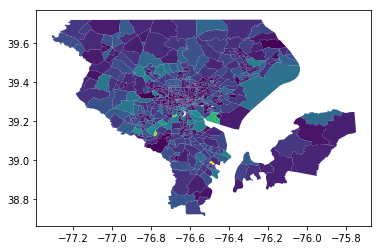

In [24]:
print('reading GeoDataFrame...')
ggf = geopandas.read_file(output_data_dir+'{0:}_metro_alldata.shp'.format(city))

print('renaming columns and setting index...')
ddf = pandas.read_csv(output_data_dir+'{0:}_metro_column_names.csv'.format(city), encoding='utf-8')
ggf.columns = ddf['varname'].tolist()
ggf = ggf.set_index(['county', 'census_tract', 'activity_year'])

ggf[ggf['amtWorkingLoans_per_sbjob_adj'] <= 80000].xs(2017, level='activity_year').plot(column='amtWorkingLoans_per_sbjob_adj', cmap='viridis')